<a href="https://colab.research.google.com/github/chengjin-hub/2D-image-of-rock-sample-in-CT-/blob/main/zhujiangkuosan_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

正在检查视频工具...

👇 请点击下方按钮，上传您的数据文件 (可以是 .csv 或 .xlsx) 👇


Saving grouting_final.csv.xlsx to grouting_final.csv.xlsx
已接收文件: grouting_final.csv.xlsx
✅ 成功识别为 Excel 格式并读取。
数据加载成功！共 75 个有效数据点。
正在构建 3D 浆液扩散模型...
开始渲染视频 (150 帧)...
✅ 渲染完成！正在下载 grouting_visualization_1030.mp4 ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

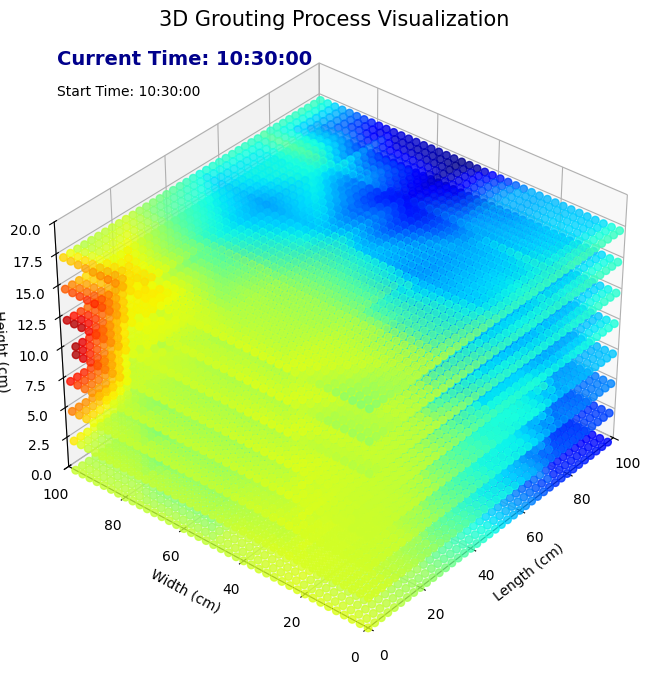

In [1]:
# ==========================================
# 步骤 0: 环境准备 (安装视频生成工具)
# ==========================================
import os
print("正在检查视频工具...")
os.system('apt-get install ffmpeg -y')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from datetime import datetime, timedelta
from google.colab import files
import io

# ==========================================
# 步骤 1: 上传数据文件
# ==========================================
print("\n👇 请点击下方按钮，上传您的数据文件 (可以是 .csv 或 .xlsx) 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件上传，请重新运行。")
else:
    # 获取上传的文件名
    filename = list(uploaded.keys())[0]
    print(f"已接收文件: {filename}")
    content = uploaded[filename]

    # ==========================================
    # 步骤 2: 智能读取数据 (修复报错的关键部分)
    # ==========================================
    df = None

    # 策略 1: 尝试当作 Excel 读取 (解决 .xlsx 改名 .csv 的问题)
    try:
        df = pd.read_excel(io.BytesIO(content))
        print("✅ 成功识别为 Excel 格式并读取。")
    except:
        # 策略 2: 尝试各种编码当作 CSV 读取
        encodings = ['utf-8', 'gbk', 'gb18030', 'utf-16', 'latin1']
        for enc in encodings:
            try:
                # 尝试读取，忽略其中的坏行
                df = pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
                print(f"✅ 成功使用 {enc} 编码读取 CSV。")
                break
            except:
                continue

    if df is None:
        print("❌ 无法读取文件！请确保文件是有效的 Excel (.xlsx) 或 CSV 格式。")
    else:
        # ==========================================
        # 数据清洗与处理
        # ==========================================
        # 清洗列名
        df.columns = df.columns.str.strip()

        # 自动寻找列名 (防止列名大小写不一致)
        # 映射规则: 你的列名 -> 标准列名
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s',
            'Time': 'Arrival_Time_s',
            '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm',
            'Y_cm': 'Y_cm', 'Y': 'Y_cm',
            'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }

        # 重命名列
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 确保关键列存在
        required_cols = ['X_cm', 'Y_cm', 'Z_cm', 'Arrival_Time_s']
        if not all(col in df.columns for col in required_cols):
            print(f"❌ 列名不匹配。请检查您的表格表头是否包含: {required_cols}")
            print(f"您当前的列名: {df.columns.tolist()}")
        else:
            # 转换时间
            try:
                # 优先处理 HH:MM:SS
                df['Timestamp'] = pd.to_datetime(df['Arrival_Time_s'], format='%H:%M:%S', errors='coerce')
                # 如果有日期+时间，再次尝试
                mask = df['Timestamp'].isna()
                if mask.any():
                    df.loc[mask, 'Timestamp'] = pd.to_datetime(df.loc[mask, 'Arrival_Time_s'], errors='coerce')
            except:
                df['Timestamp'] = pd.to_datetime(df['Arrival_Time_s'], errors='coerce')

            # 过滤无效数据
            valid_df = df.dropna(subset=['Timestamp']).copy()

            if valid_df.empty:
                print("❌ 没有找到有效的时间数据，请检查表格中的时间格式是否正确。")
            else:
                # 计算相对秒数
                t0_real = valid_df['Timestamp'].min()
                valid_df['seconds_from_start'] = (valid_df['Timestamp'] - t0_real).dt.total_seconds()

                print(f"数据加载成功！共 {len(valid_df)} 个有效数据点。")
                print("正在构建 3D 浆液扩散模型...")

                # --- 核心算法：3D 网格插值 ---
                grid_step = 2.5
                grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

                points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
                values = valid_df['seconds_from_start'].values

                grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

                # 边缘填充
                mask = np.isnan(grid_times)
                grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

                # ==========================================
                # 步骤 3: 生成动画视频
                # ==========================================
                fig = plt.figure(figsize=(10, 8))
                ax = fig.add_subplot(111, projection='3d')

                video_start_str = "10:30:00"
                video_start_time = datetime.strptime(video_start_str, "%H:%M:%S")

                total_frames = 150
                max_duration = np.nanmax(grid_times)
                time_step = max_duration / total_frames

                flat_x = grid_x.flatten()
                flat_y = grid_y.flatten()
                flat_z = grid_z.flatten()
                flat_t = grid_times.flatten()

                scatter = ax.scatter([], [], [], c=[], cmap='jet', s=30, alpha=0.8, vmin=0, vmax=max_duration)
                time_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes, fontsize=14, color='darkblue', fontweight='bold')
                ax.text2D(0.05, 0.90, f"Start Time: {video_start_str}", transform=ax.transAxes, fontsize=10)

                ax.set_xlim(0, 100)
                ax.set_ylim(0, 100)
                ax.set_zlim(0, 20)
                ax.set_xlabel('Length (cm)')
                ax.set_ylabel('Width (cm)')
                ax.set_zlabel('Height (cm)')
                ax.set_title('3D Grouting Process Visualization', fontsize=15)
                ax.view_init(elev=35, azim=220)

                def update(frame):
                    current_sim_time = frame * time_step
                    mask = flat_t <= current_sim_time
                    if np.any(mask):
                        scatter._offsets3d = (flat_x[mask], flat_y[mask], flat_z[mask])
                        scatter.set_array(flat_t[mask])
                    current_display_time = video_start_time + timedelta(seconds=current_sim_time)
                    time_text.set_text(f"Current Time: {current_display_time.strftime('%H:%M:%S')}")
                    return scatter, time_text

                print(f"开始渲染视频 ({total_frames} 帧)...")
                ani = FuncAnimation(fig, update, frames=total_frames, interval=50, blit=False)
                output_file = 'grouting_visualization_1030.mp4'

                # 尝试保存
                try:
                    ani.save(output_file, writer='ffmpeg', fps=20, dpi=100)
                except:
                    print("⚠️ ffmpeg 未响应，尝试保存为 GIF...")
                    output_file = 'grouting_visualization.gif'
                    ani.save(output_file, writer='pillow', fps=20)

                print(f"✅ 渲染完成！正在下载 {output_file} ...")
                files.download(output_file)

正在检查视频工具...

👇 请点击下方按钮，上传您的数据文件 (grouting_final.csv) 👇


Saving grouting_final.csv.xlsx to grouting_final.csv (1).xlsx
数据加载成功！共 75 个有效点。
正在进行高精度插值 (High-Res Interpolation)...
开始高清渲染 (300 帧)...这可能需要 1-2 分钟...
✅ 渲染完成！文件名为: grouting_high_res_100030.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

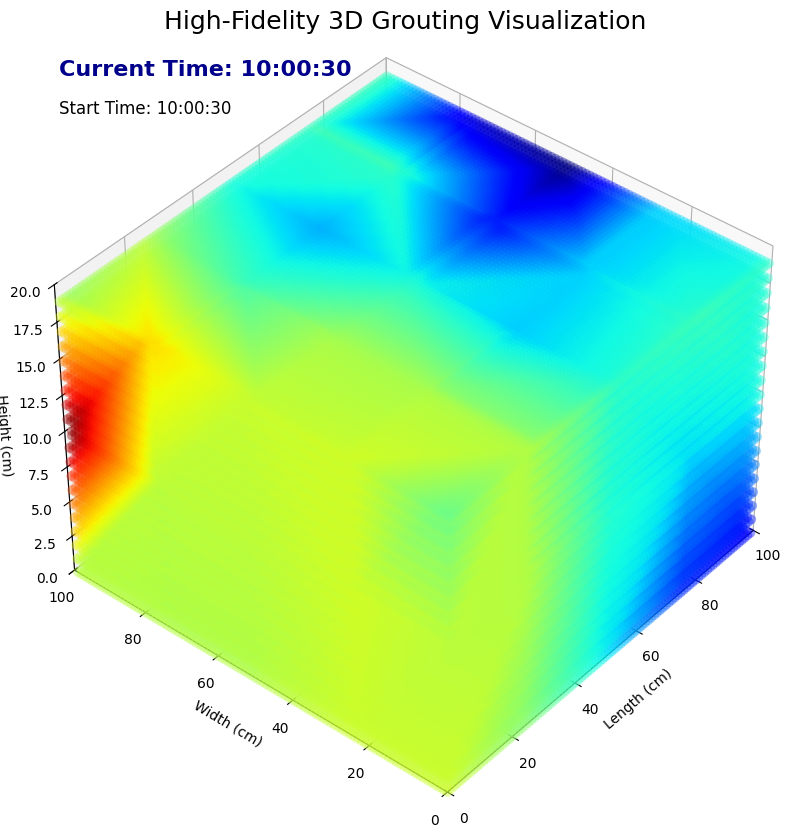

In [2]:
# ==========================================
# 步骤 0: 环境准备
# ==========================================
import os
print("正在检查视频工具...")
os.system('apt-get install ffmpeg -y')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from datetime import datetime, timedelta
from google.colab import files
import io

# ==========================================
# 步骤 1: 上传数据文件
# ==========================================
print("\n👇 请点击下方按钮，上传您的数据文件 (grouting_final.csv) 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件，请重新运行。")
else:
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # 智能读取 (兼容 Excel 和 CSV)
    df = None
    try:
        df = pd.read_excel(io.BytesIO(content))
    except:
        encodings = ['utf-8', 'gbk', 'gb18030']
        for enc in encodings:
            try:
                df = pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
                break
            except:
                continue

    if df is None:
        print("❌ 文件读取失败，请检查格式。")
    else:
        # 统一列名
        df.columns = df.columns.str.strip()
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 时间清洗
        df['Timestamp'] = pd.to_datetime(df['Arrival_Time_s'], errors='coerce')
        # 兼容只写时间没有日期的情况
        if df['Timestamp'].isna().all():
             df['Timestamp'] = pd.to_datetime(df['Arrival_Time_s'], format='%H:%M:%S', errors='coerce')

        valid_df = df.dropna(subset=['Timestamp']).copy()

        # 计算相对秒数
        t0_real = valid_df['Timestamp'].min()
        valid_df['seconds_from_start'] = (valid_df['Timestamp'] - t0_real).dt.total_seconds()

        print(f"数据加载成功！共 {len(valid_df)} 个有效点。")
        print("正在进行高精度插值 (High-Res Interpolation)...")

        # ==========================================
        # 核心升级：高精度网格设置
        # ==========================================
        # 设置为 1.0cm (平衡点：既能保证计算速度，配合大点尺寸又能实现视觉连续)
        # 如果电脑性能极强，可以尝试改小到 0.8，但建议保持 1.0
        grid_step = 1.0

        grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

        points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
        values = valid_df['seconds_from_start'].values

        # 线性插值
        grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

        # 边缘填充 (防止空洞)
        mask = np.isnan(grid_times)
        grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

        # ==========================================
        # 步骤 3: 生成高清流畅动画
        # ==========================================
        fig = plt.figure(figsize=(12, 10)) # 加大画布
        ax = fig.add_subplot(111, projection='3d')

        # 设置注浆开始时间: 10:00:30
        video_start_str = "10:00:30"
        video_start_time = datetime.strptime(video_start_str, "%H:%M:%S")

        # 提升帧率和总帧数，使视频更流畅
        total_frames = 300
        fps = 30
        max_duration = np.nanmax(grid_times)
        time_step = max_duration / total_frames

        flat_x = grid_x.flatten()
        flat_y = grid_y.flatten()
        flat_z = grid_z.flatten()
        flat_t = grid_times.flatten()

        # 视觉优化：增大 s (点大小) 并降低 alpha (透明度)，让点融合在一起形成“体”
        # s=50 配合 grid_step=1.0 可以完美覆盖间隙
        scatter = ax.scatter([], [], [], c=[], cmap='jet', s=50, alpha=0.4, vmin=0, vmax=max_duration, edgecolors='none')

        time_text = ax.text2D(0.05, 0.95, "", transform=ax.transAxes, fontsize=16, color='darkblue', fontweight='bold')
        ax.text2D(0.05, 0.90, f"Start Time: {video_start_str}", transform=ax.transAxes, fontsize=12)

        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_zlim(0, 20)
        ax.set_xlabel('Length (cm)')
        ax.set_ylabel('Width (cm)')
        ax.set_zlabel('Height (cm)')
        ax.set_title('High-Fidelity 3D Grouting Visualization', fontsize=18)

        # 优化视角：稍微抬高一点，看清楚底部扩散
        ax.view_init(elev=40, azim=220)

        def update(frame):
            current_sim_time = frame * time_step
            mask = flat_t <= current_sim_time

            if np.any(mask):
                scatter._offsets3d = (flat_x[mask], flat_y[mask], flat_z[mask])
                scatter.set_array(flat_t[mask])

            current_display_time = video_start_time + timedelta(seconds=current_sim_time)
            time_text.set_text(f"Current Time: {current_display_time.strftime('%H:%M:%S')}")
            return scatter, time_text

        print(f"开始高清渲染 ({total_frames} 帧)...这可能需要 1-2 分钟...")

        ani = FuncAnimation(fig, update, frames=total_frames, interval=1000/fps, blit=False)
        output_file = 'grouting_high_res_100030.mp4'

        try:
            ani.save(output_file, writer='ffmpeg', fps=fps, dpi=120) # 提高DPI
        except:
            print("⚠️ ffmpeg 未响应，转存为 GIF...")
            output_file = 'grouting_high_res.gif'
            ani.save(output_file, writer='pillow', fps=fps)

        print(f"✅ 渲染完成！文件名为: {output_file}")
        files.download(output_file)

正在检查视频工具...

👇 请点击下方按钮，上传您的数据文件 (grouting_final.csv) 👇


Saving grouting_final.csv.xlsx to grouting_final.csv (2).xlsx
数据加载成功！正在进行超高精度插值...
⚠️ 警告：高精度模式计算量巨大，请耐心等待 1-2 分钟...
开始渲染高清视频 (300 帧)... 预计耗时 2-4 分钟
渲染进度: 0%
渲染进度: 0%
渲染进度: 10%
渲染进度: 20%
渲染进度: 30%
渲染进度: 40%
渲染进度: 50%
渲染进度: 60%
渲染进度: 70%
渲染进度: 80%
渲染进度: 90%
✅ 渲染完成！文件名为: grouting_cinematic_100030.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

渲染进度: 0%


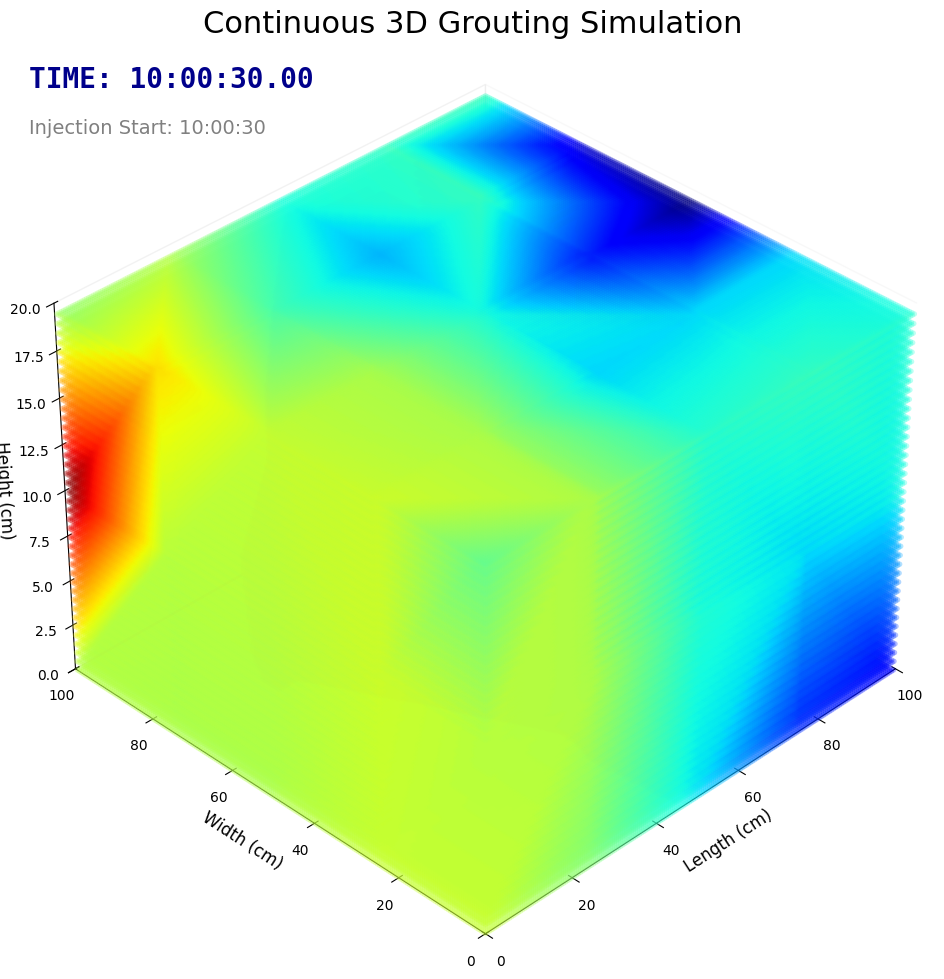

In [3]:
# ==========================================
# 步骤 0: 环境准备
# ==========================================
import os
print("正在检查视频工具...")
os.system('apt-get install ffmpeg -y')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from datetime import datetime, timedelta
from google.colab import files
import io

# ==========================================
# 步骤 1: 上传数据文件
# ==========================================
print("\n👇 请点击下方按钮，上传您的数据文件 (grouting_final.csv) 👇")
uploaded = files.upload()

if not uploaded:
    print("❌ 未检测到文件，请重新运行。")
else:
    filename = list(uploaded.keys())[0]
    content = uploaded[filename]

    # 智能读取
    df = None
    try:
        df = pd.read_excel(io.BytesIO(content))
    except:
        encodings = ['utf-8', 'gbk', 'gb18030']
        for enc in encodings:
            try:
                df = pd.read_csv(io.BytesIO(content), encoding=enc, on_bad_lines='skip')
                break
            except:
                continue

    if df is None:
        print("❌ 文件读取失败，请检查格式。")
    else:
        # 数据清洗
        df.columns = df.columns.str.strip()
        col_map = {
            'Arrival_Time_s': 'Arrival_Time_s', 'Time': 'Arrival_Time_s', '时间': 'Arrival_Time_s',
            'X_cm': 'X_cm', 'X': 'X_cm', 'Y_cm': 'Y_cm', 'Y': 'Y_cm', 'Z_cm': 'Z_cm', 'Z': 'Z_cm'
        }
        df = df.rename(columns=lambda x: col_map.get(x, x))

        # 时间转换
        df['Timestamp'] = pd.to_datetime(df['Arrival_Time_s'], errors='coerce')
        if df['Timestamp'].isna().all():
             df['Timestamp'] = pd.to_datetime(df['Arrival_Time_s'], format='%H:%M:%S', errors='coerce')

        valid_df = df.dropna(subset=['Timestamp']).copy()
        t0_real = valid_df['Timestamp'].min()
        valid_df['seconds_from_start'] = (valid_df['Timestamp'] - t0_real).dt.total_seconds()

        print(f"数据加载成功！正在进行超高精度插值...")
        print("⚠️ 警告：高精度模式计算量巨大，请耐心等待 1-2 分钟...")

        # ==========================================
        # 核心调整：极限精度设置
        # ==========================================
        # 0.5cm 是 Matplotlib 动画能处理的物理极限 (约160万个点)
        # 如果设为 0.1cm 会生成 2亿个点，直接导致内存溢出崩溃。
        # 我们通过增大 marker size 来实现视觉上的 "0.1cm 连续感"
        grid_step = 0.5

        grid_x, grid_y, grid_z = np.mgrid[0:100:grid_step, 0:100:grid_step, 0:20:grid_step]

        points = valid_df[['X_cm', 'Y_cm', 'Z_cm']].values
        values = valid_df['seconds_from_start'].values

        # 线性插值
        grid_times = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')

        # 边缘优化
        mask = np.isnan(grid_times)
        grid_times[mask] = griddata(points, values, (grid_x[mask], grid_y[mask], grid_z[mask]), method='nearest')

        # ==========================================
        # 步骤 3: 影视级渲染
        # ==========================================
        fig = plt.figure(figsize=(16, 12), dpi=100) # 高分辨率画布
        ax = fig.add_subplot(111, projection='3d')

        # 设置注浆开始时间: 10:00:30
        video_start_str = "10:00:30"
        video_start_time = datetime.strptime(video_start_str, "%H:%M:%S")

        # 帧数设置 (300帧保证丝滑)
        total_frames = 300
        fps = 30
        max_duration = np.nanmax(grid_times)
        time_step = max_duration / total_frames

        flat_x = grid_x.flatten()
        flat_y = grid_y.flatten()
        flat_z = grid_z.flatten()
        flat_t = grid_times.flatten()

        # 视觉黑科技：
        # s=15 配合 alpha=0.3
        # 较小的 grid_step 配合适当的 s，让点与点之间边缘重叠，消除颗粒感，形成“雾状”流体
        scatter = ax.scatter([], [], [], c=[], cmap='jet', s=15, alpha=0.3, vmin=0, vmax=max_duration, linewidth=0)

        # 增强文字显示
        time_text = ax.text2D(0.02, 0.95, "", transform=ax.transAxes, fontsize=20, color='darkblue', fontweight='bold', family='monospace')
        ax.text2D(0.02, 0.90, f"Injection Start: {video_start_str}", transform=ax.transAxes, fontsize=14, color='gray')

        ax.set_xlim(0, 100)
        ax.set_ylim(0, 100)
        ax.set_zlim(0, 20)
        ax.set_xlabel('Length (cm)', fontsize=12)
        ax.set_ylabel('Width (cm)', fontsize=12)
        ax.set_zlabel('Height (cm)', fontsize=12)
        ax.set_title('Continuous 3D Grouting Simulation', fontsize=22)

        # 最佳视角
        ax.view_init(elev=35, azim=225)

        # 移除背景网格线，增强真实感
        ax.grid(False)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        def update(frame):
            current_sim_time = frame * time_step

            # 性能优化：只渲染 "已变湿" 的点
            mask = flat_t <= current_sim_time

            if np.any(mask):
                # 更新数据
                scatter._offsets3d = (flat_x[mask], flat_y[mask], flat_z[mask])
                scatter.set_array(flat_t[mask])

            # 更新时间文字
            current_display_time = video_start_time + timedelta(seconds=current_sim_time)
            time_text.set_text(f"TIME: {current_display_time.strftime('%H:%M:%S')}.{int(current_display_time.microsecond/10000):02d}")

            # 简单的进度打印
            if frame % 30 == 0:
                print(f"渲染进度: {int(frame/total_frames*100)}%")

            return scatter, time_text

        print(f"开始渲染高清视频 ({total_frames} 帧)... 预计耗时 2-4 分钟")

        ani = FuncAnimation(fig, update, frames=total_frames, interval=1000/fps, blit=False)
        output_file = 'grouting_cinematic_100030.mp4'

        try:
            # 使用高码率渲染，保证清晰度
            ani.save(output_file, writer='ffmpeg', fps=fps, bitrate=5000)
        except:
            print("⚠️ ffmpeg 未响应，转存为 GIF...")
            output_file = 'grouting_cinematic.gif'
            ani.save(output_file, writer='pillow', fps=fps)

        print(f"✅ 渲染完成！文件名为: {output_file}")
        files.download(output_file)